In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
#import torch.cuda
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal

#conda activate base
cudaOn = False

In [2]:
tepLoc = "C:/Users/Charlie/Desktop/TEP_Data/"
#tepTrain = tepLoc + "TEP_Faulty_Training.csv"
tepTrain = tepLoc + "TEP_FaultFree_Training.csv"
#tepTest = tepLoc + "TEP_FaultFree_Testing.csv"
tepTest = tepLoc + "TEP_Faulty_Testing.csv"
#tepTrain = '/content/TEP_Faulty_Training.csv'
#tepTest = '/content/TEP_Faulty_Testing.csv'

scaler = StandardScaler()

#data = pd.read_csv('c172_file_1.csv')
data = pd.read_csv(tepTrain)
#data2 = pd.read_csv(tepTrain2)
#data = pd.concat([data,data2])
dataTest = pd.read_csv(tepTest)
#I should only be scaling the values that are double values, scaling fault number and other stuff just kinda fucks output
#scaler.fit(dataTest)
#data = pd.DataFrame(scaler.transform(data))
#dataTest = pd.DataFrame(scaler.transform(dataTest))


In [3]:
data = data.drop('Unnamed: 0',axis=1)
data = data.drop('faultNumber',axis=1)
data = data.drop('simulationRun',axis=1)
data = data.drop('sample',axis=1)

faultNumbersTest = []
faultNumbersT = dataTest.get('faultNumber')
for i in faultNumbersT:
    faultNumbersTest.append(i)

"""
faultNumbersTest = []
faultNumbersT = dataTest.get('faultNumber')
for i in faultNumbersT:
    if i != 1:
        faultNumbersTest.append(1)
    else:
        faultNumbersTest.append(0)
"""
dataTest = dataTest.drop('Unnamed: 0',axis=1)
dataTest = dataTest.drop('faultNumber',axis=1)
dataTest = dataTest.drop('simulationRun',axis=1)
dataTest = dataTest.drop('sample',axis=1)
#dataTest = dataTest.iloc(0)[strtOfTwo:strtOfTwo+500]
data = data.astype('float64')
dataTest = dataTest.astype('float64')

In [4]:
#print(faultNumbersT[10000:10100])
print(faultNumbersTest[10000:10100])

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [5]:
print(dataTest)
numVariables = 52

         xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  xmeas_6  xmeas_7  \
0        0.25171   3672.4   4466.3   9.5122   27.057   42.473   2705.6   
1        0.25234   3642.2   4568.7   9.4145   26.999   42.586   2705.2   
2        0.24840   3643.1   4507.5   9.2901   26.927   42.278   2703.5   
3        0.25153   3628.3   4519.3   9.3347   26.999   42.330   2703.9   
4        0.21763   3655.8   4571.0   9.3087   26.901   42.402   2707.7   
...          ...      ...      ...      ...      ...      ...      ...   
9599995  0.26494   3719.6   4536.7   9.2265   26.875   42.401   2708.3   
9599996  0.25252   3724.0   4494.3   9.1873   27.221   41.999   2706.0   
9599997  0.25164   3700.8   4537.3   9.2514   26.659   42.180   2704.7   
9599998  0.29097   3641.8   4525.2   9.3053   26.823   42.234   2705.0   
9599999  0.29359   3622.2   4485.1   9.3070   26.922   42.610   2704.8   

         xmeas_8  xmeas_9  xmeas_10  ...   xmv_2   xmv_3   xmv_4   xmv_5  \
0         74.750   120.41   0.33642

In [6]:
def tep_testing_stepped(dat,step_size):
    res = []
    ind = 0
    scale = MinMaxScaler().fit(dat)
    dat = pd.DataFrame(scale.transform(dat))
    #print(int((len(data)/step_size)))
    for i in range(int((len(dat)/step_size))):
        if ind + step_size < len(dat):
            step = []
            for j in range(step_size):
              #print(data.iloc(0)[ind])#[ind])
              step.append(dat.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

#t = tep_testing_stepped(dataTest,5)
#t = to_var(t)
#print(len(t[0][0]))

In [7]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = x[start:(start+batch_size)]
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD
    
def tep_testing_stepped(dat,step_size):
    res = []
    ind = 0
    scale = MinMaxScaler().fit(dat)
    dat = pd.DataFrame(scale.transform(dat))
    #print(int((len(data)/step_size)))
    for i in range(int((len(dat)/step_size))):
        if ind + step_size < len(dat):
            step = []
            for j in range(step_size):
              #print(data.iloc(0)[ind])#[ind])
              step.append(dat.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

In [8]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #z = z.float()
        z = model(z)
        #print(z)
        tensorZ = z[0]#torch.tensor(z[0])
        #print(tensorZ.shape)
        #print(z[0])
        return self.decoder(tensorZ), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [9]:
step_size = 9
batch = 512
index_step_length = numVariables
epochs = 20

num = 3

d = 2
k = 1

base_mu, base_cov = torch.zeros(2), torch.eye(2)

base_mu = to_var(base_mu.double())
base_cov = to_var(base_cov.double())

base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
#XX.cuda()
demo = VAE(index_step_length,h_dim=36,z_dim=2)
model = stacked_NVP(d, k, hidden=512,n=num)
demo.double()
model.double()
    
#next set of tests should be with n=3, last set was with n=1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.RMSprop(demo.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

if torch.cuda.is_available() & cudaOn:
    demo.cuda()
    print("demo done")
    model.cuda()
    print("model done")

C:\Users\Charlie\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20] Loss: 0.633
Epoch[1/20] Loss: 0.633
Epoch[1/20] Loss: 0.632
Epoch[1/20] Loss: 0.632
Epoch[1/20] Loss: 0.632
Epoch[2/20] Loss: 0.634
Epoch[2/20] Loss: 0.631
Epoch[2/20] Loss: 0.634
Epoch[2/20] Loss: 0.632
Epoch[2/20] Loss: 0.634
Epoch[3/20] Loss: 0.632
Epoch[3/20] Loss: 0.634
Epoch[3/20] Loss: 0.633
Epoch[3/20] Loss: 0.634
Epoch[3/20] Loss: 0.633
Epoch[4/20] Loss: 0.631
Epoch[4/20] Loss: 0.632
Epoch[4/20] Loss: 0.633
Epoch[4/20] Loss: 0.633
Epoch[4/20] Loss: 0.635
Epoch[5/20] Loss: 0.631
Epoch[5/20] Loss: 0.633
Epoch[5/20] Loss: 0.633
Epoch[5/20] Loss: 0.632
Epoch[5/20] Loss: 0.633
Epoch[6/20] Loss: 0.632
Epoch[6/20] Loss: 0.634
Epoch[6/20] Loss: 0.631
Epoch[6/20] Loss: 0.632
Epoch[6/20] Loss: 0.632
Epoch[7/20] Loss: 0.635
Epoch[7/20] Loss: 0.632
Epoch[7/20] Loss: 0.633
Epoch[7/20] Loss: 0.633
Epoch[7/20] Loss: 0.635
Epoch[8/20] Loss: 0.632
Epoch[8/20] Loss: 0.632
Epoch[8/20] Loss: 0.632
Epoch[8/20] Loss: 0.632
Epoch[8/20] Loss: 0.633
Epoch[9/20] Loss: 0.633
Epoch[9/20] Loss

C:\Users\Charlie\AppData\Local\Temp/ipykernel_24380/2293436802.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  p4 = plt.figure()


55

0.006610985679878656
0.038102977849465175
6.332519494950395e-05
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
55

0.005327694633340563
0.05150155148679303
6.467137384544904e-05
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
55

0.018803466975625616
0.027042749427613658
4.105974609760338e-05
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
55

0.00144949908880337

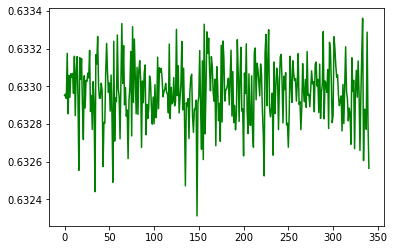

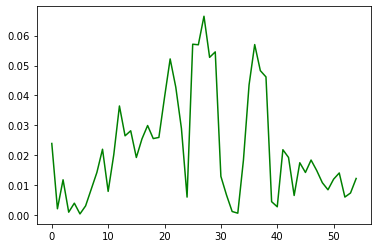

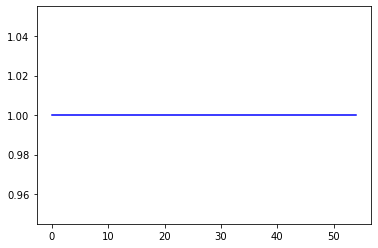

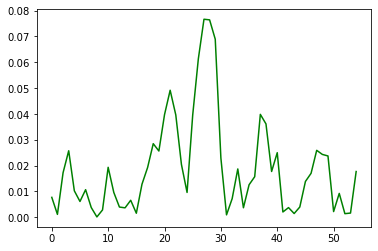

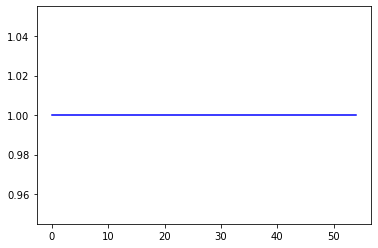

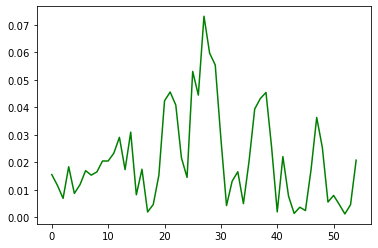

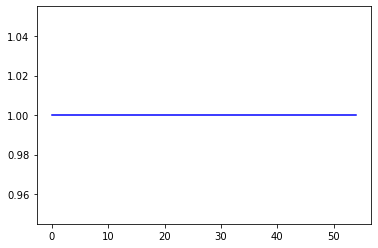

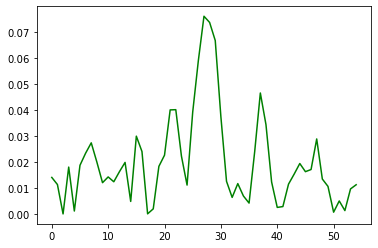

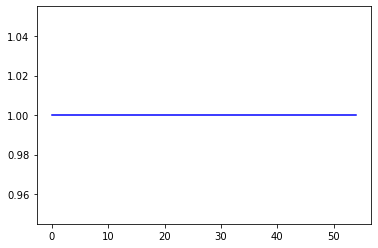

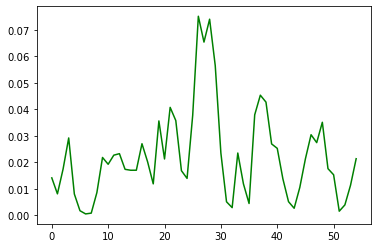

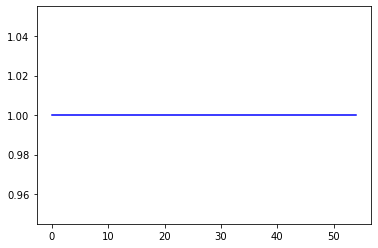

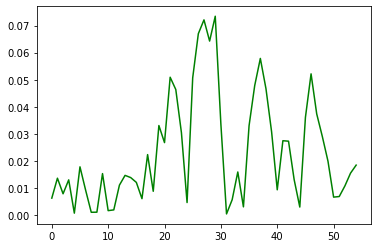

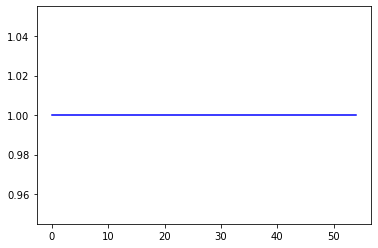

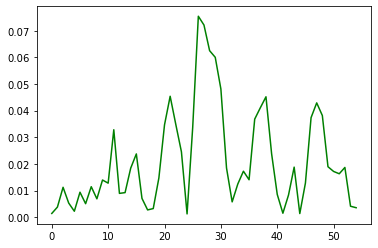

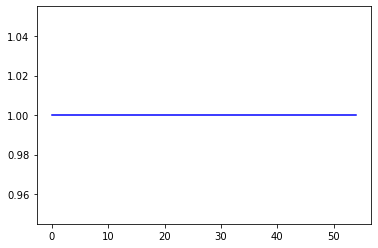

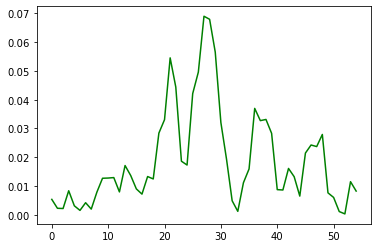

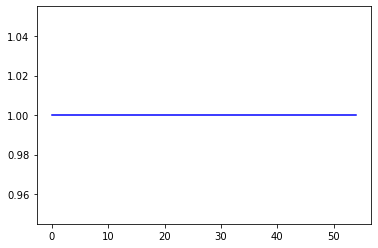

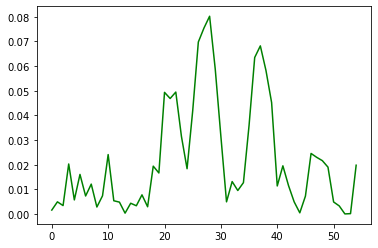

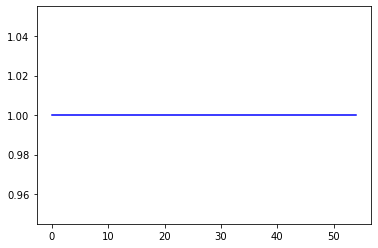

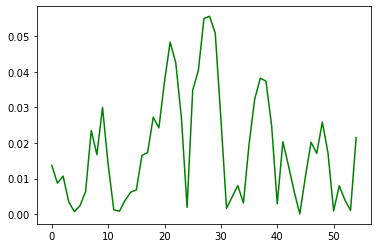

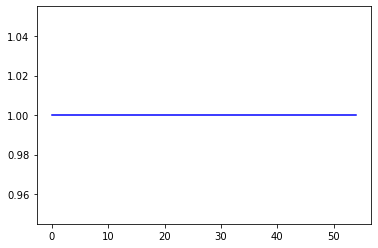

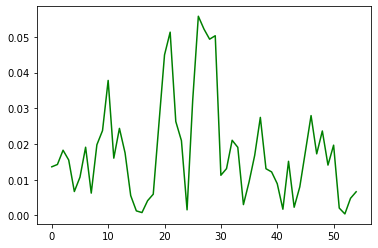

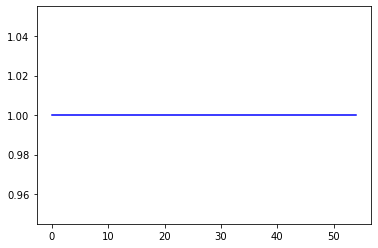

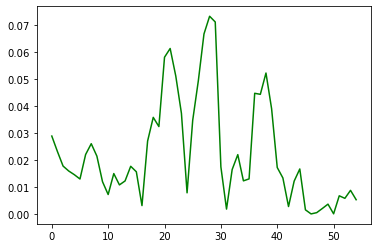

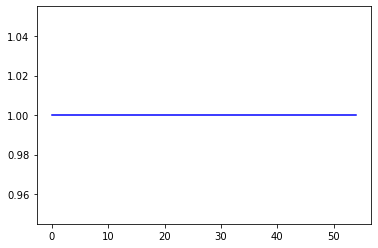

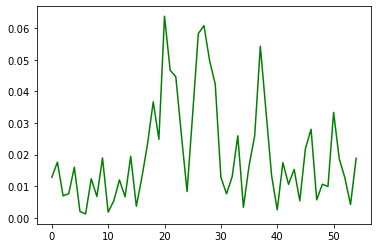

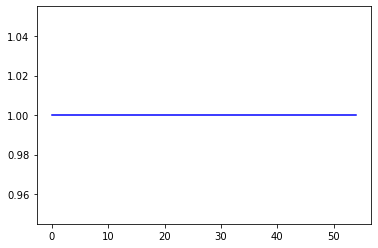

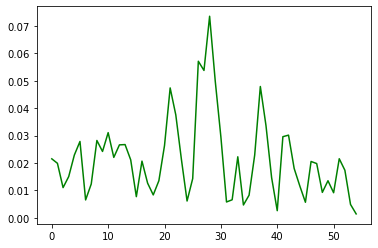

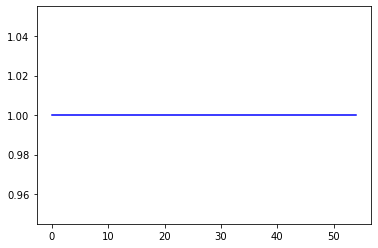

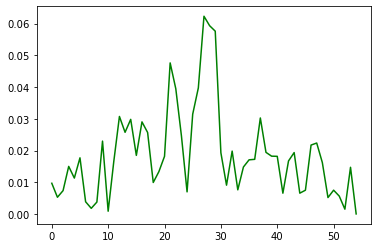

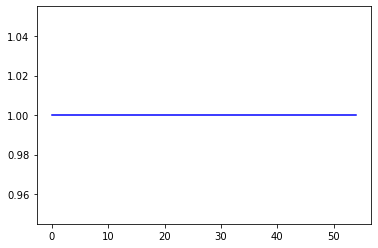

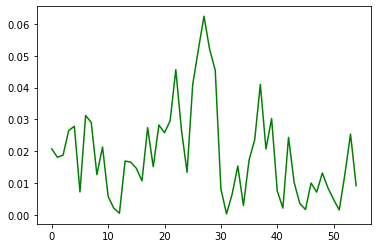

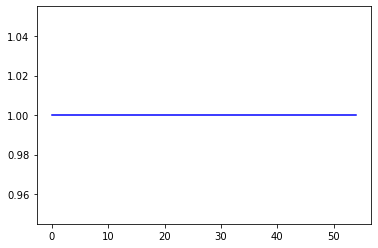

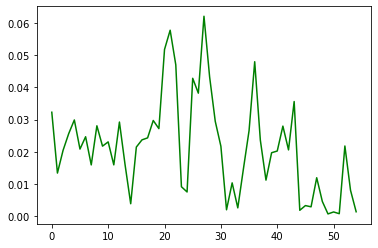

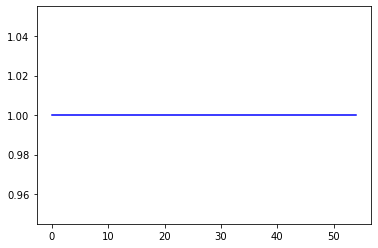

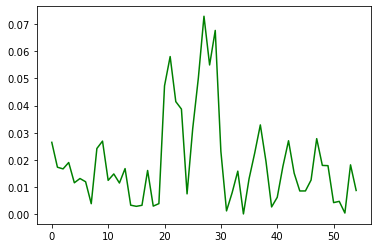

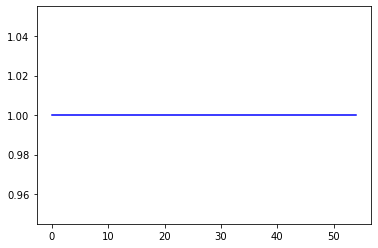

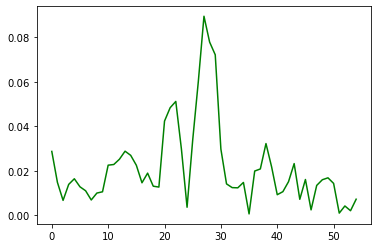

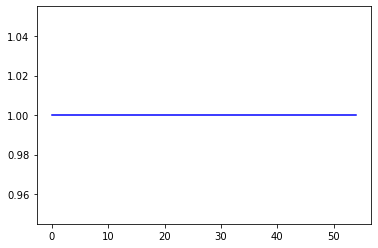

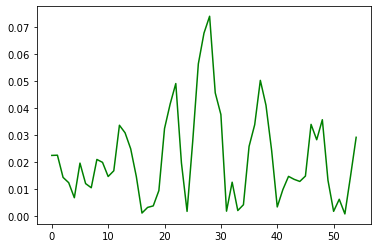

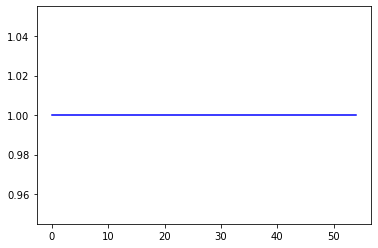

In [14]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(X,batch)
    #print(range(batch))
    for i in range(batch):
        #localX = torch.tensor(b[i].cuda())
        localX = to_var(torch.tensor(b[i]))
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""
        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()
        scheduler.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = abs(torch.mean(localX-recon))

        if idx%30 == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))
            
p = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')

strtOfTwo = int(len(dataTest)/20)
sets = []
runNum = 0 
print(len(faultNumbersTest))
print("////////////////////")
for i in range(20):
    print(str(strtOfTwo*runNum) + " : " + str((strtOfTwo*runNum)+500))
    print(faultNumbersTest[strtOfTwo*runNum])
    dt = dataTest[strtOfTwo*runNum:(strtOfTwo*runNum)+500]
    t1 = tep_testing_stepped(dt,step_size)
    sets.append(t1)
    runNum = runNum + 1
print("////////////////////")
setNum = 0
for set in sets:
    step_start = 0
    anomalies = []
    y_nomalies = []
    county = 0
    #print(type(XX))
    #print(len(XX))
    #print(XX.shape)
    for step in set:
      step = to_var(torch.tensor(step,dtype=torch.float64))
      if True:
          #step = torch.tensor(XX[step_start:step_start+step_size])[0]
          recon,_,_ = demo(step)
          anom = abs(torch.mean(step-recon))
          anom2 = torch.mean(torch.tensor(faultNumbersTest[(setNum*strtOfTwo)+(county*step_size):(setNum*strtOfTwo)+(county*step_size+step_size)],dtype=torch.float64))
          #if county%100 == 0:
            #print("step: " + str(step))
            #print("recon: " + str(recon))
            #print(anom)
          anomalies.append(anom)
          y_nomalies.append(anom2)
          step_start = step_start + 1
          county = county + 1
    setNum = setNum + 1
    start = 0
    view = []
    max = -99999
    min = 99999
    maxA = -99999
    minA = 99999

    print(len(anomalies))

    for a in anomalies:
        if start+1 < len(anomalies):
            view.append(abs(anomalies[start+1].item() - a.item()))  
            start = start + 1

    for i in range(len(view)):
        j = i + 1
        if view[i] > max:
            max = a.item()
        if view[i] < min:
            min = a.item()
        if i < len(view)-1:
            #print("i: " + str(view[i]))
            #print("j: " + str(view[j]))
            v = abs(view[i]-view[j])
            #print("v: " + str(v))
            if v > maxA:
                maxA = v
            if v < minA:
                minA = v

    print()
    print(max)
    print(maxA)
    print(minA)

    #could get loc min and max given a step size rather than literally between individual points

    p3 = plt.figure()
    plt.plot(anomalies, 'g-')
    p4 = plt.figure()
    plt.plot(y_nomalies, 'b-')
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")